<a href="https://colab.research.google.com/github/ElenaIurchenkoMatlas/Contribute-To-This-Project/blob/master/Project_DeveloperSurvey23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import tempfile

#Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Salary scaler
from sklearn.preprocessing import StandardScaler
#Try to find clusters
from sklearn.cluster import KMeans

# Authenticate with the Kaggle API using your API token
api = KaggleApi()
api.authenticate()

# Create a temporary directory to store the dataset
with tempfile.TemporaryDirectory() as temp_dir:
    # Download the dataset files
    api.dataset_download_files('stackoverflow/stack-overflow-2023-developers-survey', path=temp_dir, unzip=True)

    # List files in the directory to find the CSV file
    for file_name in os.listdir(temp_dir):
        print(file_name)

    csv_file_path = os.path.join(temp_dir, 'survey_results_public.csv')

    # Read the CSV file
    df = pd.read_csv(csv_file_path)
    # Remove the first columns
    df.drop(df.columns[[0, 1]], axis=1, inplace=True)
    # Reset the index
    df.reset_index(drop=True, inplace=True)
    print(df.head())
# "C:\Users\iurch\.kaggle\kaggle (1).json"

Dataset URL: https://www.kaggle.com/datasets/stackoverflow/stack-overflow-2023-developers-survey
survey_results_schema.csv
README_2023.txt
so_survey_2023.pdf
survey_results_public.csv
                       MainBranch              Age  \
0                   None of these  18-24 years old   
1  I am a developer by profession  25-34 years old   
2  I am a developer by profession  45-54 years old   
3  I am a developer by profession  25-34 years old   
4  I am a developer by profession  25-34 years old   

                                          Employment  \
0                                                NaN   
1                                Employed, full-time   
2                                Employed, full-time   
3                                Employed, full-time   
4  Employed, full-time;Independent contractor, fr...   

                             RemoteWork  \
0                                   NaN   
1                                Remote   
2  Hybrid (some remote, s

In [ ]:
# Check initial shape
initial_shape = df.shape
print("Initial shape:", initial_shape)
#89185, 82

Initial shape: (89184, 82)


In [ ]:
# Identify duplicates
# df.duplicated().sum() # shows no dupplicates
duplicates = df.duplicated().sum()
duplicates

#We detected 1203 dupplicates

1203

In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Check shape after dropping duplicates
final_shape = df.shape
print("Final shape:", final_shape)

#Shape now: 87982, 82 - dupplicates a deleted

Final shape: (87981, 82)


In [ ]:
df.columns

Index(['MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities',
       'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence',
       'TechList', 'BuyNewTool', 'Country', 'Currency', 'CompTotal',
       'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith',
       'OpSysPersonal use', 'OpSysProfessional use',
       'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith',
       'OfficeStackSyncHaveWorkedWith', 'OfficeStackSyncWantToWorkWith',
       'AISearchHaveWorkedWith', 'AISearchWantToWorkWith',
       'AIDevHa

In [ ]:
nan_count = df['ConvertedCompYearly'].isnull().sum()
print(f"Number of NaN values in 'ConvertedCompYearly': {nan_count}")

#Number of NaN values in 'ConvertedCompYearly': 39962

Number of NaN values in 'ConvertedCompYearly': 39962


In [ ]:
# Drop rows where 'ConvertedCompYearly' is NaN
df.dropna(subset=['ConvertedCompYearly'], inplace=True)

In [ ]:
#Verifying that the rows have been dropped
nan_count_after = df['ConvertedCompYearly'].isnull().sum()
print(f"Number of NaN values in 'ConvertedCompYearly' after dropping: {nan_count_after}")

Number of NaN values in 'ConvertedCompYearly' after dropping: 0


Data Preprocessing Steps:
1) We have already deleted duplicates and missing values from target variable column as well.

2) Next we can do:
- Drop all irrelevant columns,
- handle out missing values - replacing them with K-Nearest i.e. or most frequent value (mode) or just delete

3) Categorical to Numeric Values - "Age" to mean Categories, for None - mode, 4) Mapping + mean for this time relevant numerical columns : YearsOfCode, YearsOfCodePro, WorkExp. OrgSize - mean

4) Normalization/Scaling - Column SalaryUSD

6) Features

In [ ]:
class DeveloperDataTransformer:
    def __init__(self):
        #Scaller for Salary Column
        self.scaler = StandardScaler()
        # Define the mappings, for better reading - short descriptions for MainBranch, Employment and RemoteWork
        self.branch_mapping = {
            'I am a developer by profession': 'Developer',
            'I am not primarily a developer, but I write code sometimes as part of my work/studies': 'I can code',
            'I am learning to code': 'Code Student',
            'I code primarily as a hobby': 'Hobby',
            'I used to be a developer by profession, but no longer am': 'Ex-Developer',
            'None of these': 'Other branch',
        }
        self.employment_mapping = {
            'Employed, full-time': 'Fulltime employed',
            'Student, full-time': 'Fulltime student',
            'Independent contractor, freelancer, or self-employed': 'Freelancer',
            'Not employed, but looking for work': 'Jobless',
            'Student, part-time': 'Parttime student',
            'Employed, part-time': 'Parttime employed',
            'Not employed, and not looking for work': 'Longterm jobless',
            'Retired': 'Retired'
        }
        self.remote_work_mapping = {
            'Remote': 'Remote',
            'Hybrid (some remote, some in-person)': 'Hybrid',
            'In-person': 'In-person'
        }
        #CompSize - mean
        self.company_size_mapping = {
            'Just me - I am a freelancer, sole proprietor, etc.': 1,
            '2 to 9 employees': 5,
            '10 to 19 employees': 15,
            '20 to 99 employees': 60,
            '100 to 499 employees': 300,
            '500 to 999 employees': 750,
            '1,000 to 4,999 employees': 2500,
            '5,000 to 9,999 employees': 7500,
            '10,000 or more employees': 10000,
            'I don’t know': np.nan
        }

    # Some columns are carrying irrelevant information for our problem solving and can be dropped
    def drop_irrelevant_columns(self, df, columns_to_drop):
        df.drop(columns=columns_to_drop, inplace=True)
        return df

    # Simple short description for Employment, Branch and Remote Work columns
    def transform_column(self, df, column, mapping):
        df[column + '_Simple'] = df[column].map(mapping)
        return df

    def transform_employment(self, df, column):
        return self.transform_column(df, column, self.employment_mapping)

    def transform_branch(self, df, column):
        return self.transform_column(df, column, self.branch_mapping)

    def transform_remote_work(self, df, column):
        df[column] = df[column].replace(self.remote_work_mapping)
        return df

    # Here we transform Age column in mean of two values represented in each column
    def transform_age(self, df, column):
        df[column] = df[column].str.extract(r'(\d+)-(\d+)').astype(float).mean(axis=1)
        df[column].fillna(df[column].mode()[0], inplace=True)  # Fill NaN values with mode
        df[column].fillna(17, inplace=True)  # For age "Under 18 years old", take 17
        df[column] = df[column].round().astype(np.int32)
        return df

    # Column Years of Code Total have some numeric values, but datatype is string, so we adjust it
    def transform_years_code(self, df, column):
        def convert_years_code(value):
            if pd.isnull(value):
                return np.nan
            if value == 'Less than 1 year':
                return 1
            if value == 'More than 50 years':
                return 51
            try:
                return int(value)
            except ValueError:
                return np.nan

        df[column] = df[column].apply(convert_years_code)
        df[column] = df[column].fillna(df[column].mean()).astype(np.int32)  # Fill NaN values with mean
        return df

    # Company size
    def transform_company_size(self, df, column):
        # Map company sizes to numerical values, preserving NaN values
        df[column] = df[column].map(lambda x: self.company_size_mapping.get(x, x))
        # Convert the column to the desired numerical data type (float32) to handle NaN values
        df[column] = df[column].astype(np.float32)
        return df

    # For columns with relatively same information we use concatenation
    def combine_columns(self, df, col1, col2, new_col_name):
        df[new_col_name] = df[col1].fillna('') + '; ' + df[col2].fillna('')
        return df

    # Rename columns
    def rename_cols(self, df, columns_to_rename):
        return df.rename(columns=columns_to_rename)

    # Salary Column scaling
    def fit_transform_column(self, df, column):
        df[column] = df[column].astype(float)
        df[column] = df[column].fillna(df[column].median())
        df[column] = self.scaler.fit_transform(df[column].values.reshape(-1, 1))
        return df

    # Filtering untrustworthy Data in WorkExperience, YearsCode and YearsCodePro Columns
    def filter_data(self, df, age_column='Age', work_exp_column='WorkExp', years_code_column='YearsCode', years_code_pro_column='YearsCodePro'):
        filtered_df = df[
        (df[work_exp_column] < df[age_column]) &
        (df[years_code_column] < df[age_column]) &
        (df[years_code_pro_column] <= df[work_exp_column])
        ]
        return filtered_df

    # Function to fill NaN values with the mode
    def fill_with_mode(self, df, columns):
        for column in columns:
            if df[column].isnull().sum() > 0:  # Only if there are NaN values
                mode_value = df[column].mode()[0]  # Get the mode of the column
                df[column].fillna(mode_value, inplace=True)
        return df


    # def filter_countries_with_min_count(self, df, column_name='Country', min_count=10):
    #     # Occurrences of each country
    #     country_counts = df[column_name].value_counts()
    #     # Include only countries with more than min_count occurrences
    #     countries_to_include = country_counts[country_counts > min_count].index
    #     filtered_df = df[df[column_name].isin(countries_to_include)]
    #     return df

In [ ]:
#Here we apply the transformations
transformer = DeveloperDataTransformer()

# # Transform the columns
df = transformer.transform_branch(df, 'MainBranch') # just mapped with short descriptions
df = transformer.transform_age(df, 'Age') #mean of a range value
df = transformer.transform_employment(df, 'Employment') # just mapped with short descriptions
df = transformer.transform_remote_work(df, 'RemoteWork') # just mapped with short descriptions
df = transformer.transform_years_code(df, 'YearsCode')
df = transformer.transform_years_code(df, 'YearsCodePro')
df = transformer.transform_company_size(df, 'OrgSize')
df = transformer.fit_transform_column(df, 'ConvertedCompYearly') # Curent Total Anual Compensation Converted



In [ ]:
#Filtering untrustful info from WorkExp, YearCode and YearsCodePro
df_filtered = transformer.filter_data(df, age_column='Age', work_exp_column='WorkExp', years_code_column='YearsCode', years_code_pro_column='YearsCodePro')

In [ ]:
# Drop irrelevant columns
columns_to_drop = ['PurchaseInfluence', 'TechList', 'BuyNewTool',
                   'Currency','CompTotal', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOComm', 'SOAI',
                   'AIBen', 'AIToolNot interested in Using', 'TimeSearching', 'AINextVery different',
                   'AINextNeither different nor similar', 'AINextSomewhat similar', 'AINextVery similar',
                   'Knowledge_6', 'AINextSomewhat different', 'Frequency_1', 'Frequency_2', 'Frequency_3',
                   'SurveyLength', 'SurveyEase', 'TimeAnswering']
df_filtered = transformer.drop_irrelevant_columns(df_filtered, columns_to_drop)

In [ ]:
# Enumerate columns
df_filtered.info()

In [ ]:
# Identifying numerical columns (excluding target)
numerical_columns = df_filtered.select_dtypes(include=['int32', 'float32', 'float64']).columns.tolist()
numerical_columns.remove('ConvertedCompYearly')

In [ ]:
# Selecting categorical Colunms
categorical_columns = ['MainBranch', 'Employment', 'RemoteWork', 'EdLevel','LearnCodeCoursesCert', 'DevType', 'Country', 'LanguageHaveWorkedWith',  'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'OpSysProfessional use', 'TBranch', 'ProfessionalTech', 'Industry']

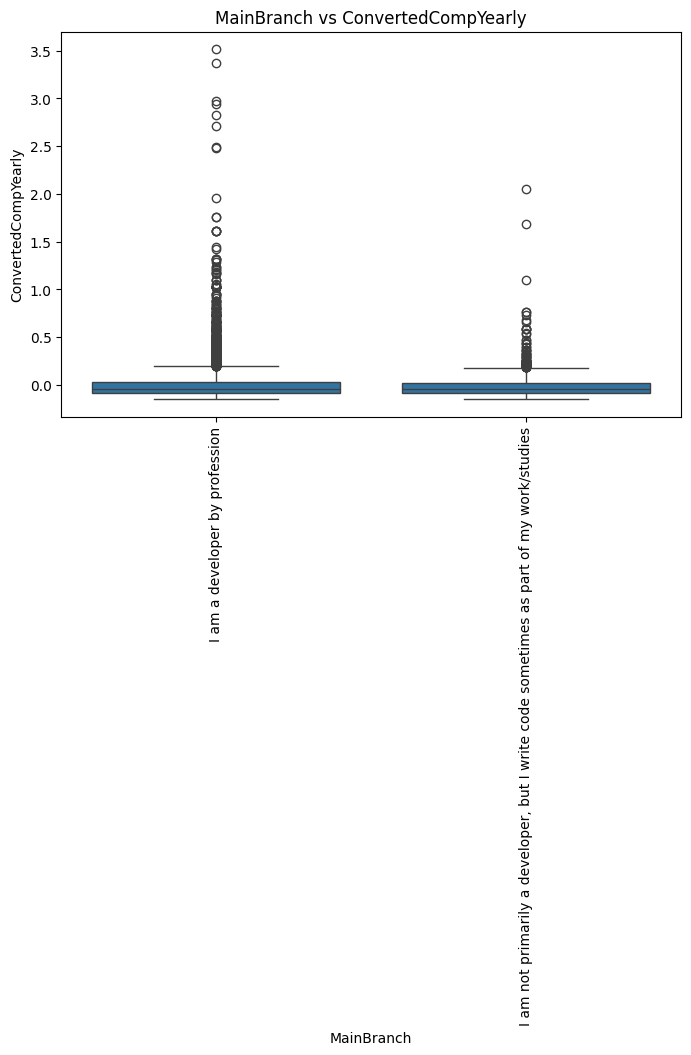

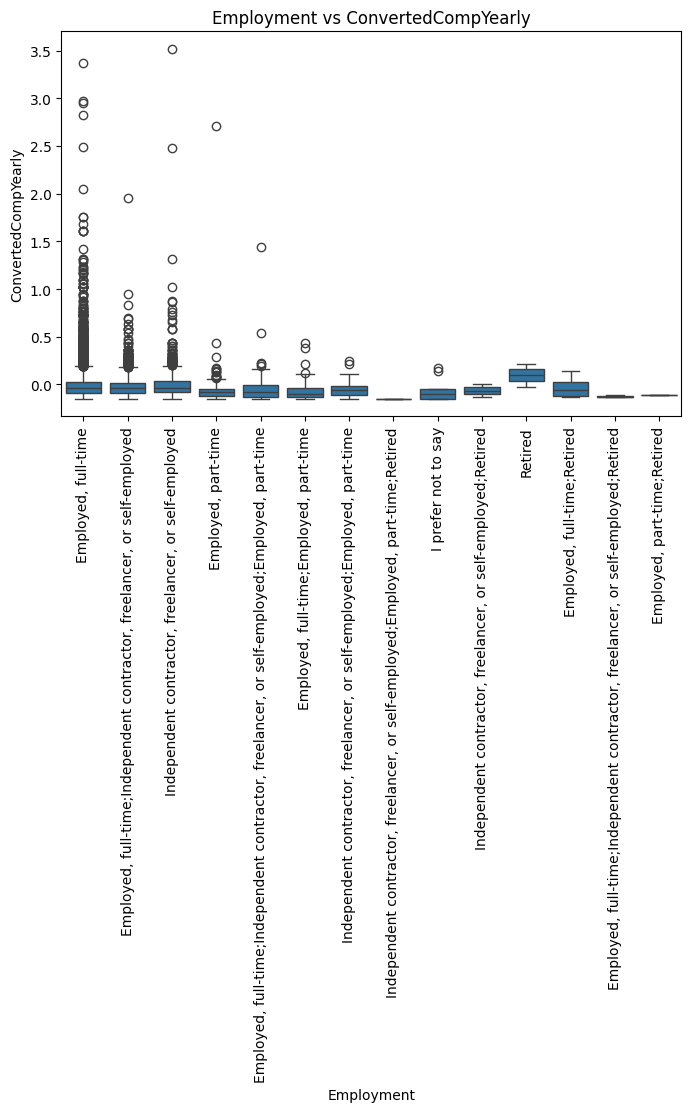

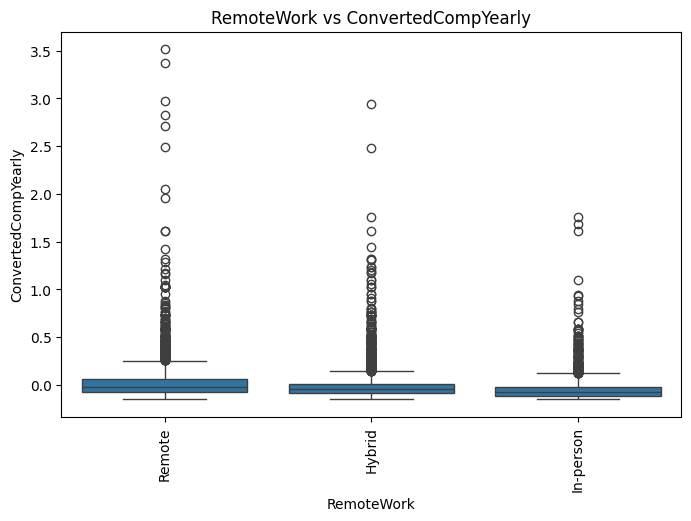

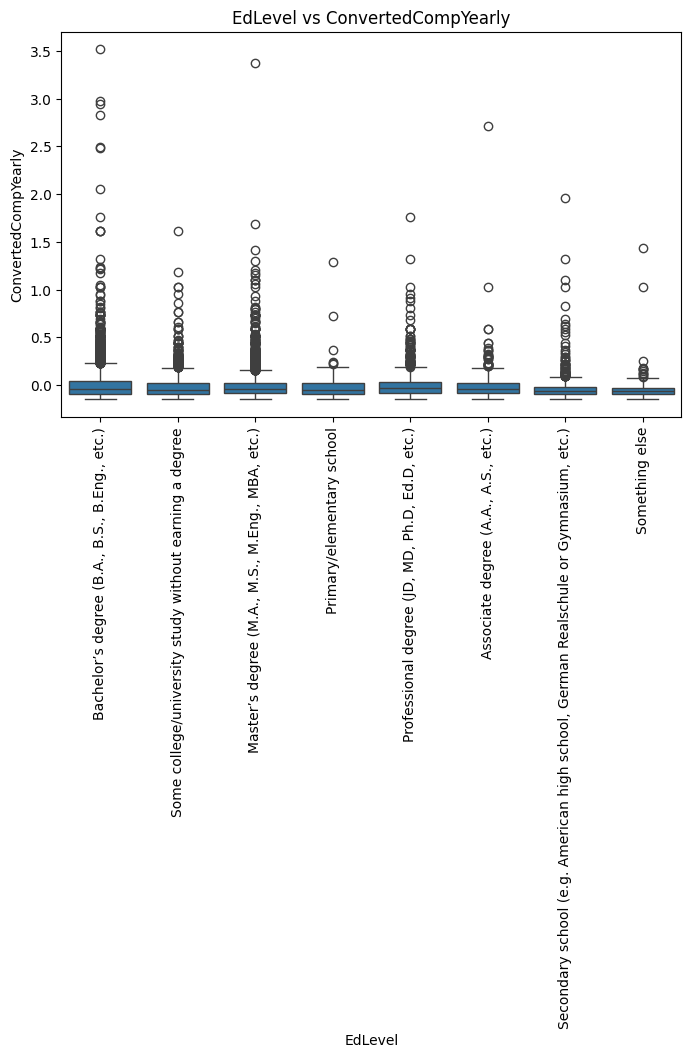

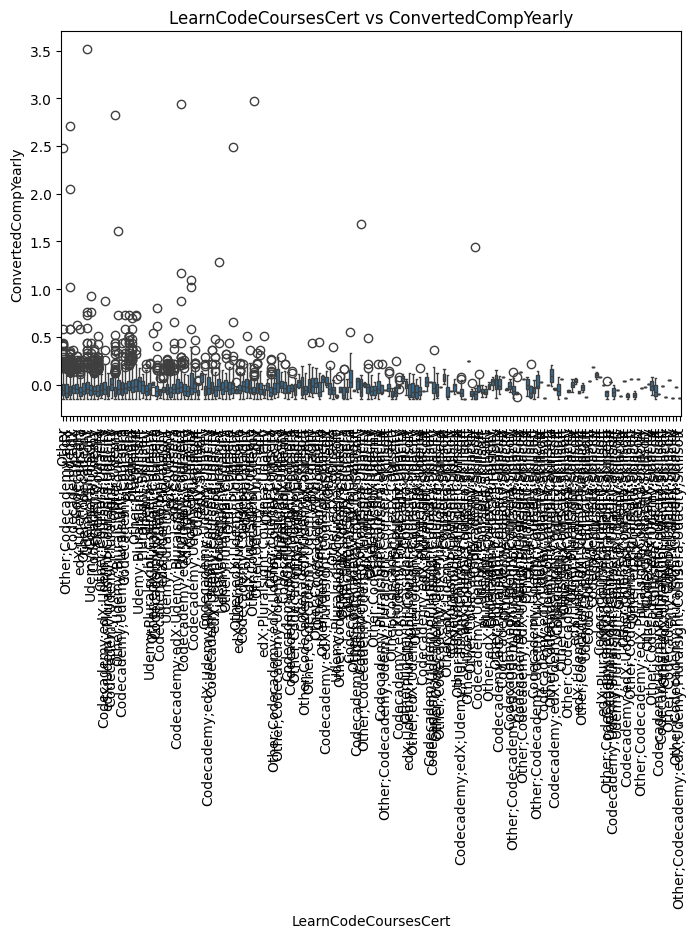

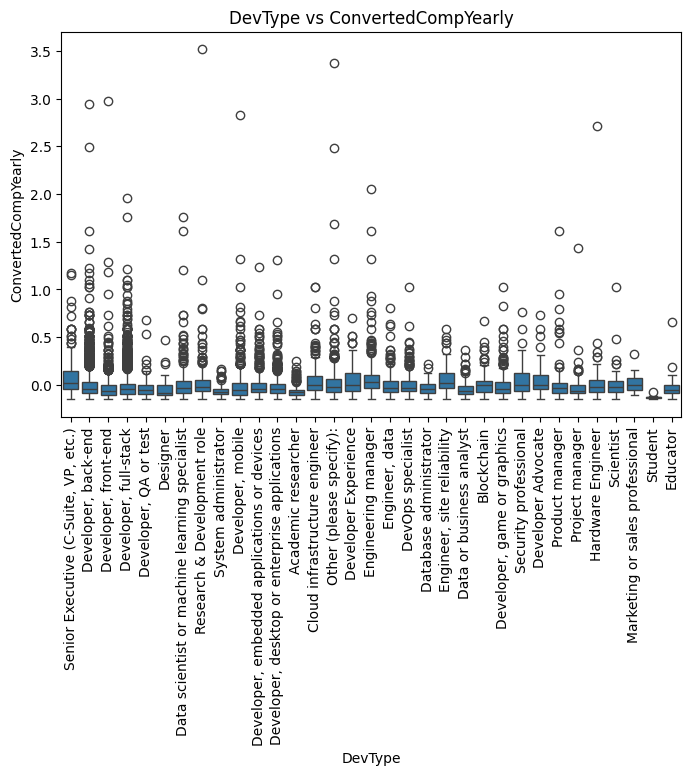

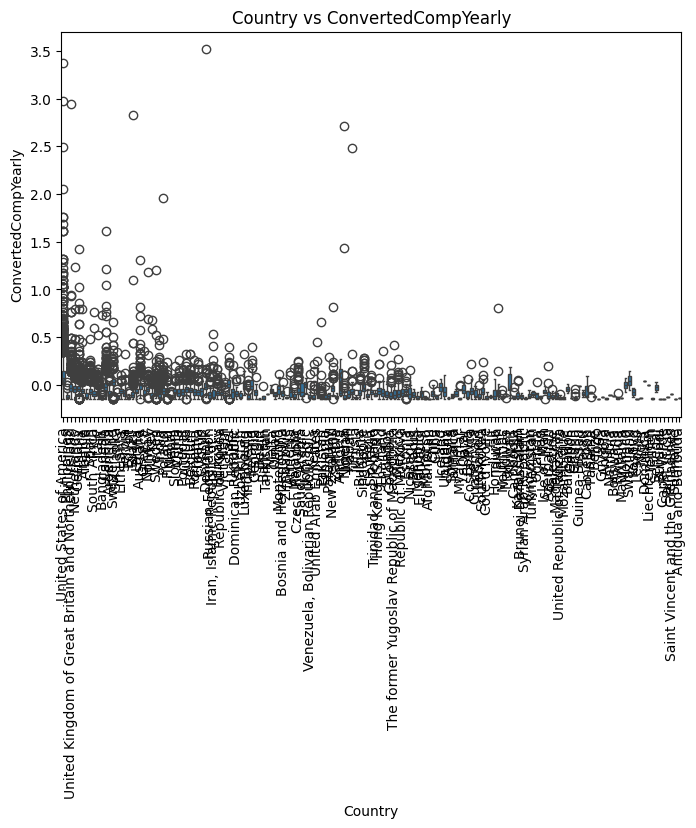

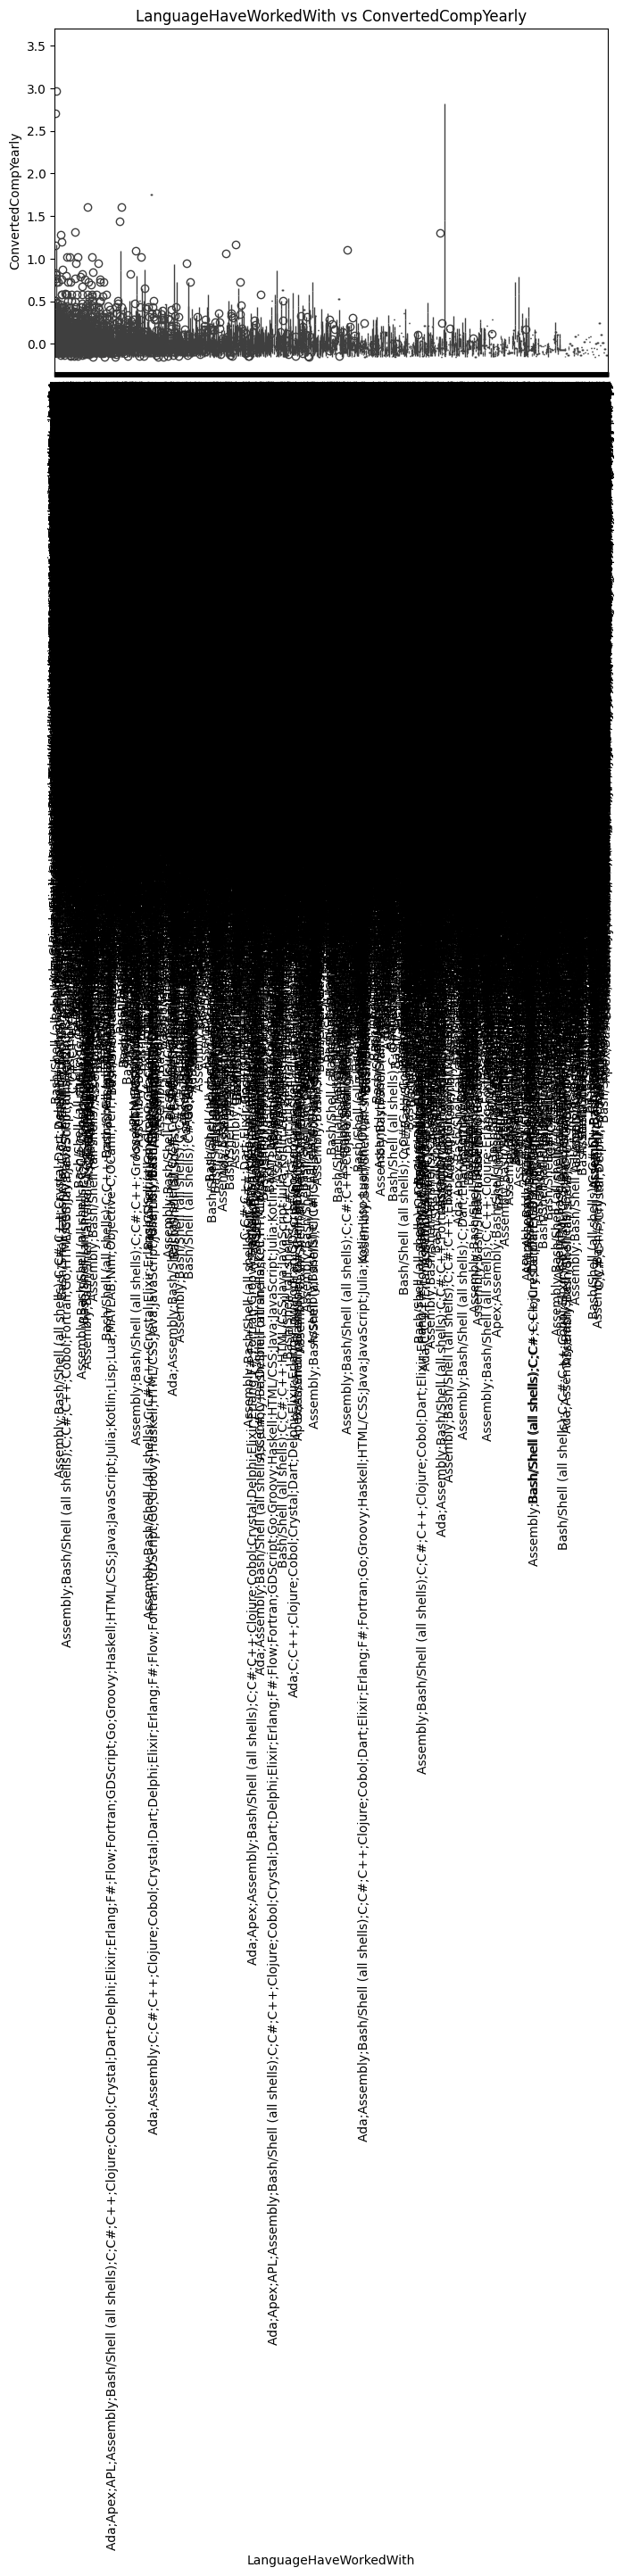

KeyboardInterrupt: 

In [ ]:
#Removing outliers from Salary column vs selected categorical columns and plot them with boxplot
df_filtered = df_filtered[(df_filtered['ConvertedCompYearly'] <= 5)]
for column in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_filtered[column], y=df_filtered['ConvertedCompYearly'])
    plt.title(f'{column} vs ConvertedCompYearly')
    plt.xticks(rotation=90)
    plt.show()


In [ ]:
#Removing outliers from Salary vs numerical columns and plot them with scatter plot
df_filtered = df_filtered[(df_filtered['ConvertedCompYearly'] <= 5)]
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df_filtered[column], y=df_filtered['ConvertedCompYearly'])
    plt.title(f'{column} vs ConvertedCompYearly')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
counts_br = df_filtered['MainBranch'].value_counts()
print(counts_br)

In [ ]:
counts_empl = df_filtered['Employment'].value_counts()
print(counts_empl)

<ipython-input-66-c82b64535d33>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


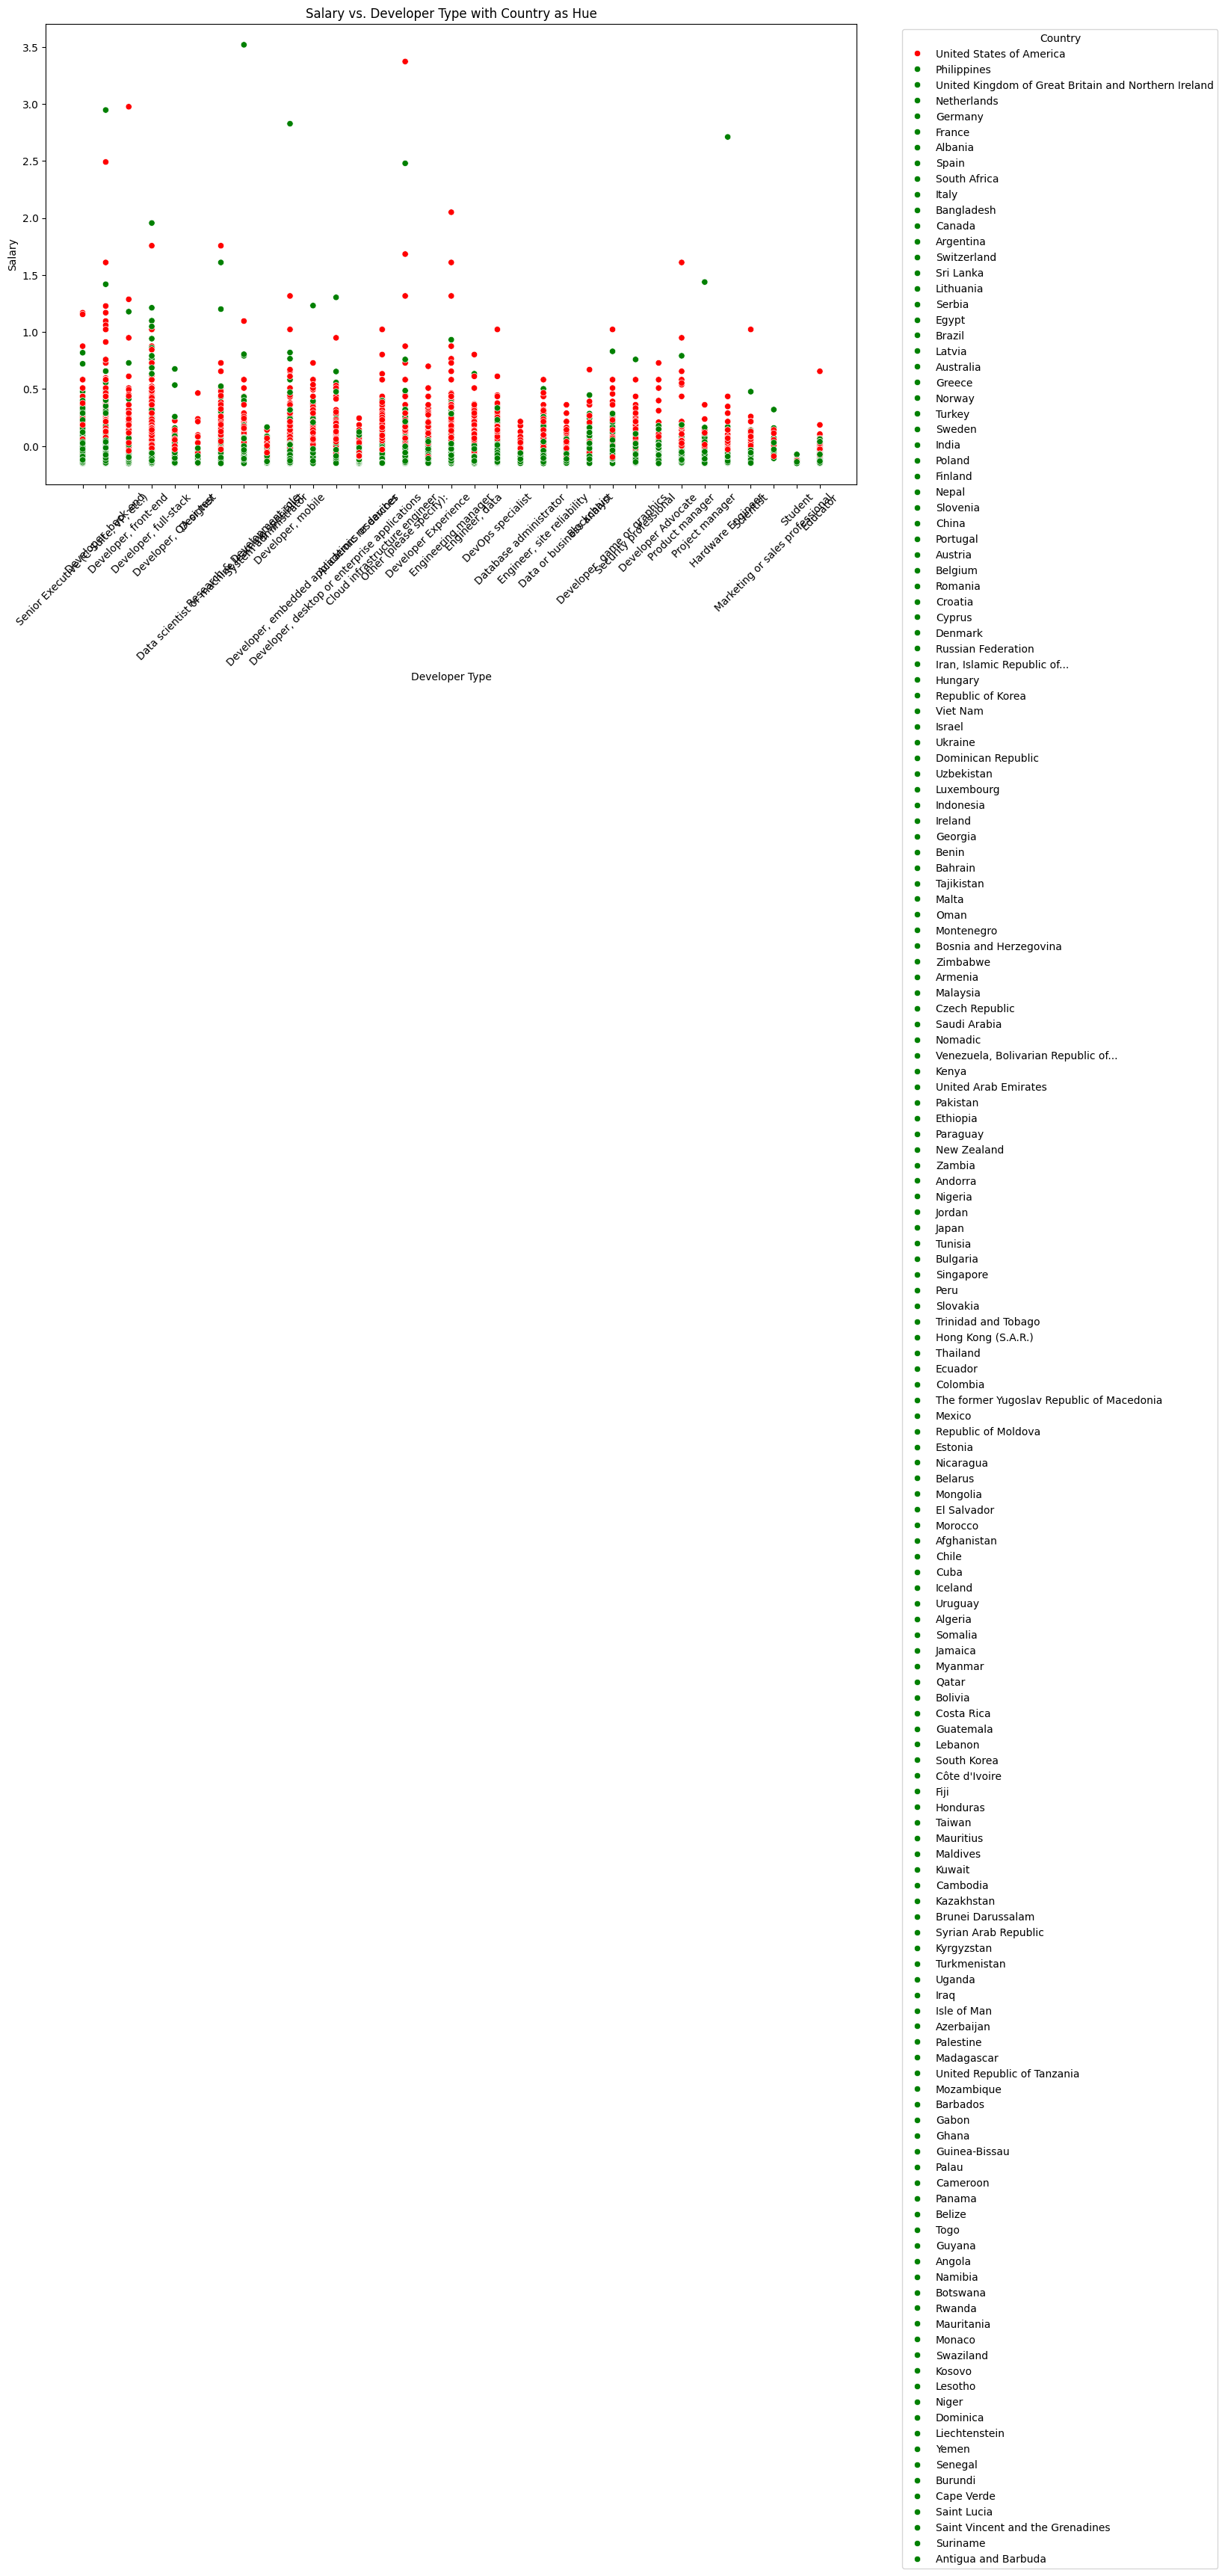

In [ ]:
country_counts = df_filtered['Country'].value_counts()
# Create a color palette based on the ranking
# Assign red to the most represented country and green to the least represented
colors = ['red' if country_counts[country] == country_counts.max() else 'green' for country in country_counts.index]

# Create a mapping from country to color
country_color_map = {country: color for country, color in zip(country_counts.index, colors)}

# Step 3: Plot the data using the custom color palette
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_filtered, x='DevType', y='ConvertedCompYearly', hue='Country', palette=country_color_map)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.title('Salary vs. Developer Type with Country as Hue')
plt.xlabel('Developer Type')
plt.ylabel('Salary')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# # Age vs. WorkExperience
# plt.figure(figsize=(4, 2))
# plt.scatter(df_filtered['Age'], df_filtered['WorkExp'], c='blue', edgecolors='w', s=100)
# plt.title('Scatter Plot of Age vs. Work Experience')
# plt.xlabel('Age')
# plt.ylabel('Work Experience')
# plt.grid(True)
# plt.show()

# #Thanks our transformations, we get working experience that is more trustful vs Age and grows exponentialy

In [ ]:
# # Age vs Salary
# plt.figure(figsize=(6, 3))
# sns.scatterplot(x='Age', y='ConvertedCompYearly', hue='WorkExp', data=df_filtered, s=100, palette='viridis')

# # Adding labels and title
# plt.title('Scatter Plot of Age vs. Salary colored by Work Experience')
# plt.xlabel('Age')
# plt.ylabel('Salary')

# # Show plot
# plt.legend(title='Work Experience')
# plt.grid(True)
# plt.show()

# #Here we can see some outliers over value 80 to be droped

In [ ]:
# remotework = np.array(df_with_boarders['RemoteWork_Remote'])
# # Convert boolean array to numeric for clustering (if needed)
# df_with_boarders['RemoteWork_Remote'] = remotework.astype(int)

# # Initialize a range of cluster numbers to test
# range_n_clusters = range(1, 10)  # Test clusters from 1 to 9

# # Store inertia values
# inertia = []

# # Calculate inertia for each cluster number
# for n_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(df_with_boarders[['ConvertedCompYearly', 'RemoteWork_Remote']])
#     inertia.append(kmeans.inertia_)

# # Plot the Elbow curve
# plt.figure(figsize=(10, 6))
# plt.plot(range_n_clusters, inertia, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.xticks(range_n_clusters)
# plt.grid(True)
# plt.show()

In [ ]:
# # Example based on elbow plot (selecting 3 clusters)
# optimal_n_clusters = 3

# # Fit K-means clustering model with optimal number of clusters
# kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
# df_with_boarders['Cluster'] = kmeans.fit_predict(df_with_boarders[['ConvertedCompYearly', 'RemoteWork_Remote']])

# # Visualize clusters
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Country', y='ConvertedCompYearly', hue='Cluster', data=df_with_boarders, palette='viridis', s=100)
# plt.title(f'Clusters of Countries by Salary and Remote Work (K={optimal_n_clusters})')
# plt.xlabel('Country')
# plt.ylabel('Salary')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.legend(title='Cluster')
# plt.show()